In [14]:
import tensorflow as tf
import matplotlib.pyplot as plot
from tensorflow.keras import models, layers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras.optimizers import Adam
import numpy as np

In [2]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    image_size=(256,256),
    batch_size = 32,
    shuffle=True
)

Found 20638 files belonging to 15 classes.


In [3]:
class_names = data.class_names
print(data.class_names)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [4]:
# 80% dataset being used for training, 10% validation and 10% for testing
# Method that creates Training, Validation and Testing dataset
def createTrainingValidationTestingDataset(dataset):
    training_dataset_percent, validation_dataset_percent, test_dataset_percent = 0.8, 0.1, 0.1
    dataset_size = len(dataset)
    shuffle = True
    
    if shuffle:
        dataset = dataset.shuffle(10000)
    
    training_dataset = data.take(int(training_dataset_percent * dataset_size))
    validation_dataset = data.skip(int(training_dataset_percent * dataset_size)).take(int(validation_dataset_percent * dataset_size))
    test_dataset = data.skip(int(training_dataset_percent * dataset_size)).skip(int(validation_dataset_percent * dataset_size))
    
    return training_dataset, validation_dataset, test_dataset

In [5]:
training_dataset, validation_dataset, test_dataset = createTrainingValidationTestingDataset(data)

In [6]:
len(training_dataset)

516

In [7]:
len(validation_dataset)

64

In [8]:
len(test_dataset)

65

In [9]:
# Reference: https://www.tensorflow.org/tutorials/images/classification
# Configuring the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [10]:
# Reference: https://www.tensorflow.org/tutorials/images/data_augmentation
#Resizing and rescaling all the pictures
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [11]:
# Reference: https://www.tensorflow.org/tutorials/images/data_augmentation
# Data Augmentation - To increase the diversity of the training set
training_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
training_dataset = (training_dataset.map(lambda a, b: (training_augmentation(a), b), 
                                         num_parallel_calls = AUTOTUNE).prefetch(AUTOTUNE))

In [14]:
len(training_dataset)

516

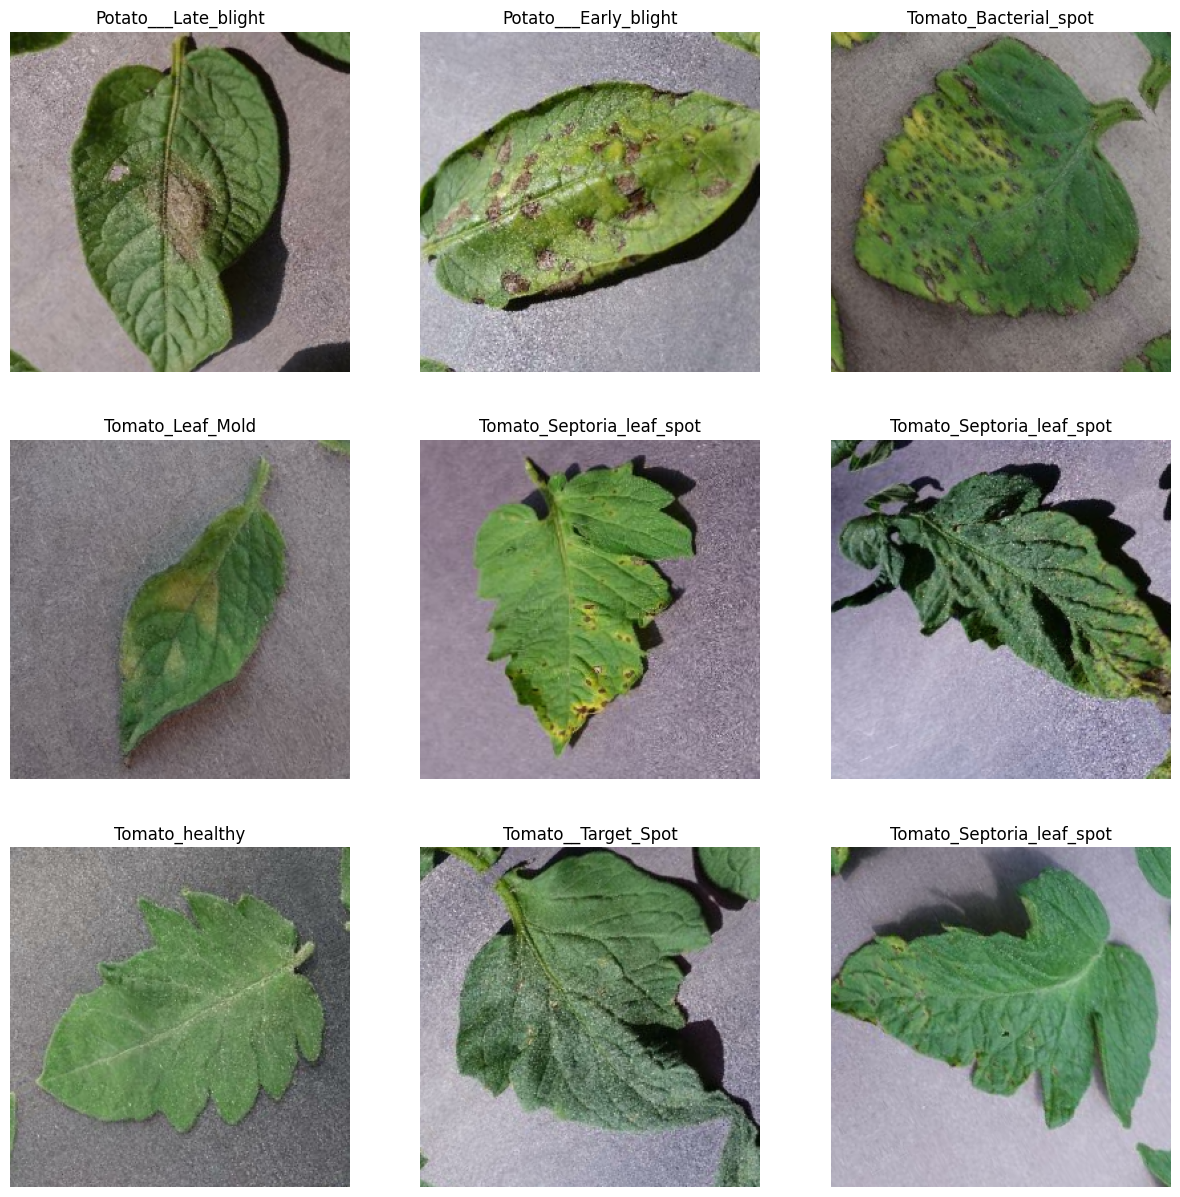

In [15]:
# Training dataset after cleaning and preprocessing
plot.figure(figsize= (15, 15))
for images, labels in training_dataset.take(1):
    for i in range(9):
        plot.subplot(3, 3, i + 1)
        plot.title(data.class_names[labels[i]])
        plot.imshow(images[i].numpy().astype("uint8"))
        plot.axis("off")

In [18]:
height, width = 256, 256
batch_size = 32
depth = 3
number_of_classes = 15
image_input_type = (batch_size, height, width, depth)

model = tf.keras.Sequential([resize_and_rescale, training_augmentation])
model.add(Conv2D(32, (3,3), input_shape=image_input_type))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), input_shape=image_input_type))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), input_shape=image_input_type))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), input_shape=image_input_type))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), input_shape=image_input_type))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), input_shape=image_input_type))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(number_of_classes))
model.add(Activation("softmax"))

model.build(input_shape=image_input_type)

In [19]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 activation_16 (Activation)  (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                      

In [20]:
optimizer = 'adam'
loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics=['accuracy']
model.compile(optimizer,loss, metrics)

In [ ]:
model_history = model.fit(training_dataset,batch_size=32,epochs=2,validation_data=validation_dataset,verbose=1)

Epoch 1/2
275/516 [==============>...............] - ETA: 5:05 - loss: 2.1246 - accuracy: 0.3158

In [22]:
score = model.evaluate(test_dataset)

65/65 [==============================] - 24s 361ms/step - loss: 0.5875 - accuracy: 0.8503


first image to predict
actual label: Tomato_Spider_mites_Two_spotted_spider_mite
1/1 [==============================] - 0s 341ms/step
predicted label: Tomato__Target_Spot


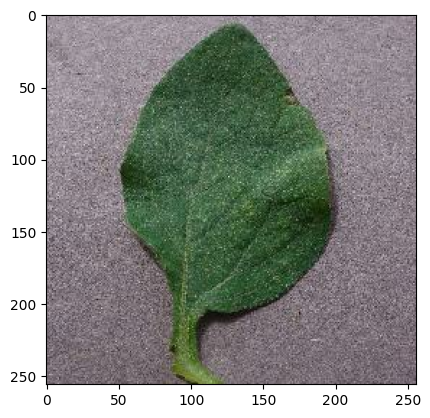

In [40]:
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plot.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])